<a href="https://colab.research.google.com/github/kumar-abhishek/imbalanced-machine-learning-book/blob/main/chapter-7/Cutmix_mixup_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running a default CNN model on Fashion MNIST dataset to benchmark it's accuracy


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import time
import torchvision
import random
import copy
import cv2
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data.sampler import  SubsetRandomSampler
seed = 44
random.seed(seed)

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        return x

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def train(train_dataloader, valid_dataloader, PATH, model = None, criterion= F.cross_entropy, epochs=1):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    model.train()
    best_acc = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        losses = 0.0
        for b_i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss = criterion(pred_prob, y) # nll is the negative likelihood loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += loss.item()
            if b_i % 10 == 0:
                print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                    epoch, b_i, len(train_dataloader),
                    100. * b_i / len(train_dataloader), loss.item()))

        train_losses.append(losses/len(train_dataloader))

        print("\n")
        print("Validation...")
        model.eval()
        loss = 0
        success = 0
        with torch.no_grad():
            for X, y in valid_dataloader:
                X, y = X.to(device), y.to(device)
                pred_prob = model(X)
                loss += criterion(pred_prob, y, reduction='sum').item()  # loss summed across the batch
                pred = pred_prob.argmax(dim=1, keepdim=True)  # use argmax to get the most likely prediction
                success += pred.eq(y.view_as(pred)).sum().item()

        loss /= len(valid_dataloader.dataset)

        val_losses.append(loss)

        accuracy = 100. * success / len(valid_dataloader.dataset)

        if (accuracy > best_acc):
          torch.save(model.state_dict(), PATH)
          best_acc = accuracy

        print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
            loss, success, len(valid_dataloader.dataset), accuracy))
    return model, train_losses, val_losses

def test(model, PATH, criterion = F.cross_entropy):
    model.eval()
    model.load_state_dict(torch.load(PATH))
    loss = 0
    success = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += criterion(pred_prob, y).item()  # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)  # use argmax to get the most likely prediction
            correct = np.squeeze(pred.eq(y.view_as(pred)))
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    accuracy = 100. * success / len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset), accuracy))

    for i in range(len(y)):
          label = y[i]
          class_correct[label] += correct[i].item()
          class_total[label] +=1
    class_percentages = []
    for i in range(len(class_correct)):
        class_percentages.append(class_correct[i] / class_total[i])

    return accuracy, class_percentages

## Orignal Fashion Mnist Dataset Class distribution

100%|██████████| 26421880/26421880 [00:02<00:00, 9809047.03it/s] 


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 173332.18it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3272975.30it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16725233.92it/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})
Distribution of classes in original dataset:


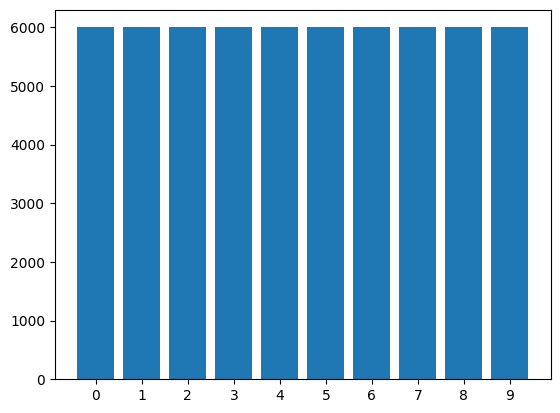

In [5]:
trainset = datasets.FashionMNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1302,), (0.3069,))]))
print(Counter(trainset.targets.numpy()))

print('Distribution of classes in original dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(trainset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

#Preparing for validaion test
indices = list(range(len(trainset)))
np.random.seed(seed)
np.random.shuffle(indices)
#to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

#Data Loader
train_dataloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
valid_dataloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)

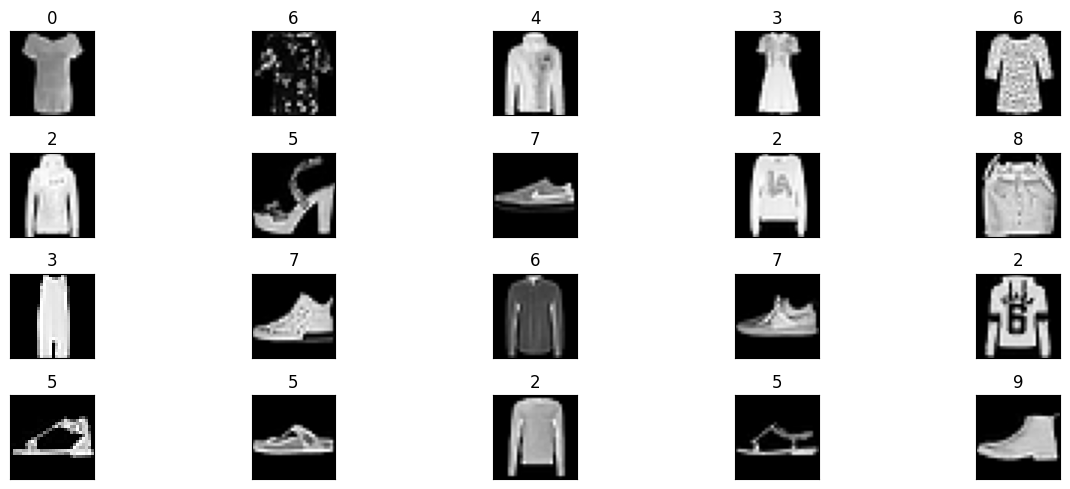

In [6]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)


fig = plt.figure(figsize=(15,5))
for idx in np.arange(20):
  # xticks=[], yticks=[] is empty to print the images without any ticks around them
  #np.sqeeze : Remove single-dimensional entries from the shape of an array.
  ax = fig.add_subplot(4, int(20/4), idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
   # .item() gets the value contained in a Tensor
  ax.set_title(labels[idx].item())
  fig.tight_layout()

In [7]:
test_ds = datasets.FashionMNIST('../data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))]))

test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=500, shuffle=True)

# Balanced/Orignal Dataset Training

In [8]:
model, train_losses, val_losses = train(train_dataloader, valid_dataloader, "Balanced_model.pth",  ConvNet().to(device), epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 0 [0/188 (0%)]	 training loss: 2.307374
epoch: 0 [10/188 (5%)]	 training loss: 1.926584
epoch: 0 [20/188 (11%)]	 training loss: 1.378142
epoch: 0 [30/188 (16%)]	 training loss: 1.431290
epoch: 0 [40/188 (21%)]	 training loss: 0.801794
epoch: 0 [50/188 (27%)]	 training loss: 0.793040
epoch: 0 [60/188 (32%)]	 training loss: 0.825342
epoch: 0 [70/188 (37%)]	 training loss: 0.789646
epoch: 0 [80/188 (43%)]	 training loss: 0.764188
epoch: 0 [90/188 (48%)]	 training loss: 0.813998
epoch: 0 [100/188 (53%)]	 training loss: 0.890873
epoch: 0 [110/188 (59%)]	 training loss: 0.657290
epoch: 0 [120/188 (64%)]	 training loss: 0.536143
epoch: 0 [130/188 (69%)]	 training loss: 0.683650
epoch: 0 [140/188 (74%)]	 training loss: 0.789976
epoch: 0 [150/188 (80%)]	 training loss: 0.577119
epoch: 0 [160/188 (85%)]	 training loss: 0.582907
epoch: 0 [170/188 (90%)]	 training loss: 0.593579
epoch: 0 [180/188 (96%)]	 training loss: 0.734903


Validation...

Test dataset: Overall Loss: 0.4401, Overall Ac

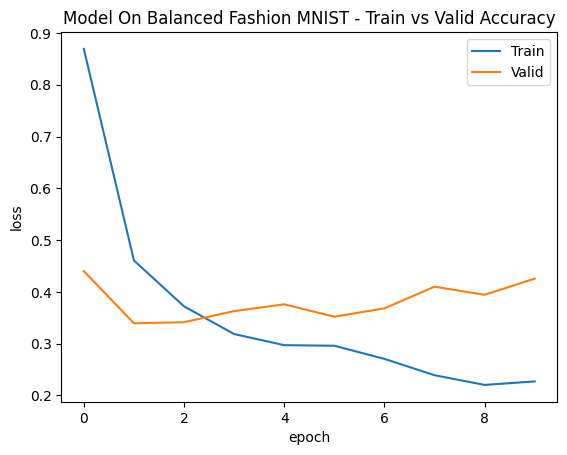

In [9]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Model On Balanced Fashion MNIST - Train vs Valid Accuracy')

plt.show()

# Test Model

In [10]:
print("On vanilla Fashion MNIST dataset")
test_acc, _ = test(model,  "Balanced_model.pth")
print("test accuracy : ", str(test_acc))

On vanilla Fashion MNIST dataset

Test dataset: Overall Loss: 0.0010, Overall Accuracy: 8565/10000 (86%)

test accuracy :  85.65


# Performance of the Model on Imbalanced MNIST Dataset

### Create Imbalanced Dataset

Distribution of classes in Imbalanced dataset:
Counter({8: 5901, 9: 5202, 2: 4912, 5: 4346, 1: 4333, 0: 4318, 4: 3739, 6: 1712, 7: 1308, 3: 799})


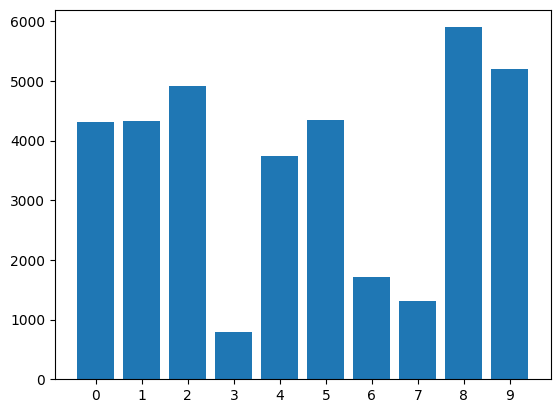

In [11]:
trainset = datasets.FashionMNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1302,), (0.3069,))]))

# generate imbalanced dataset
num_classes = 10
torch.manual_seed(seed)
sample_probs = torch.rand(num_classes)

idx_to_remove = [idx for idx, target in enumerate(train_dataloader.dataset.targets)
              if random.random() > sample_probs[target] #or target in range(3, 10)
              ]
imbalanced_train_dataset = copy.deepcopy(trainset)
imbalanced_train_dataset.targets = np.delete(trainset.targets, idx_to_remove, axis=0)
imbalanced_train_dataset.data = np.delete(trainset.data,
                                            idx_to_remove, axis=0)
print('Distribution of classes in Imbalanced dataset:')
print(Counter(imbalanced_train_dataset.targets.numpy()))
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_dataset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

#Preparing for validaion test
indices = list(range(len(imbalanced_train_dataset)))
np.random.seed(seed)
np.random.shuffle(indices)
#to get 20% of the train set
split = int(np.floor(0.2 * len(imbalanced_train_dataset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

#Data Loader
imbalanced_train_loader = torch.utils.data.DataLoader(imbalanced_train_dataset, sampler=train_sample, batch_size=64)
imbalanced_valid_loader = torch.utils.data.DataLoader(imbalanced_train_dataset, sampler=valid_sample, batch_size=64)

### train model on imbalanced dataset

In [12]:
imbalanced_model, train_losses, val_losses = train(imbalanced_train_loader, imbalanced_valid_loader,  "Imbalanced_model.pth", ConvNet().to(device), epochs=30)

epoch: 0 [0/115 (0%)]	 training loss: 2.325553
epoch: 0 [10/115 (9%)]	 training loss: 1.479495
epoch: 0 [20/115 (17%)]	 training loss: 1.004243
epoch: 0 [30/115 (26%)]	 training loss: 0.754550
epoch: 0 [40/115 (35%)]	 training loss: 0.780550
epoch: 0 [50/115 (43%)]	 training loss: 1.162335
epoch: 0 [60/115 (52%)]	 training loss: 0.974005
epoch: 0 [70/115 (61%)]	 training loss: 0.683488
epoch: 0 [80/115 (70%)]	 training loss: 0.762303
epoch: 0 [90/115 (78%)]	 training loss: 0.994353
epoch: 0 [100/115 (87%)]	 training loss: 0.679220
epoch: 0 [110/115 (96%)]	 training loss: 0.789492


Validation...

Test dataset: Overall Loss: 0.5291, Overall Accuracy: 23110/36570 (63%)

epoch: 1 [0/115 (0%)]	 training loss: 0.556050
epoch: 1 [10/115 (9%)]	 training loss: 0.934432
epoch: 1 [20/115 (17%)]	 training loss: 0.677294
epoch: 1 [30/115 (26%)]	 training loss: 0.359929
epoch: 1 [40/115 (35%)]	 training loss: 0.488925
epoch: 1 [50/115 (43%)]	 training loss: 0.657448
epoch: 1 [60/115 (52%)]	 trainin

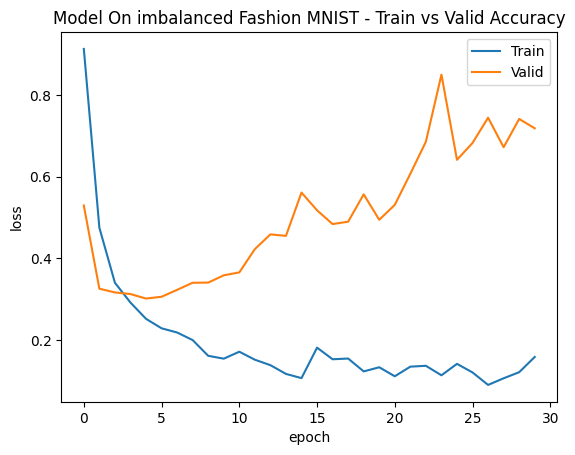

In [13]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Model On imbalanced Fashion MNIST - Train vs Valid Accuracy')

plt.show()

### test on test set

In [14]:
print("On imbalanced MNIST dataset")
test_acc1, class_percentages1 = test(imbalanced_model, "Imbalanced_model.pth")
print("test accuracy : ", str(test_acc1))

On imbalanced MNIST dataset

Test dataset: Overall Loss: 0.0017, Overall Accuracy: 8454/10000 (85%)

test accuracy :  84.54


## Cutmix Image Augmentation

In [15]:
# Adapted from https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py

def rand_bbox(size, lam):
    """

    :param size: torch.Size. Shape:(batch_size, channel, image_size, image_size)
    :param lam: cutmix rate
    :return: box boundary
    """
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets, alpha):
    """

    :param data: torch.Size. Shape:(batch_size, channel, image_size, image_size)
    :param targets: torch.Tensor. multitask, multi-classification, target1. shape(batch_size, 1)
    :param alpha: float, positive
    :return: resulting image, multi-target
    """
    indices = torch.randperm(data.size(0))
    # shuffled_data = data[indices]
    targets_a = targets
    targets_b = targets[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets_a, targets_b, lam]
    return data, targets

In [16]:
def train_cut_mix(train_dataloader, valid_dataloader, PATH, model = None, criterion= F.cross_entropy, epochs=1):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    model.train()
    best_acc = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        losses = 0.0
        for b_i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            X, ys = cutmix(X, y, alpha=0.75)
            pred_prob = model(X)
            targets1, targets2, lam = ys[0], ys[1], ys[2]
            loss = lam * criterion(pred_prob, targets1) + (1 - lam) * criterion(pred_prob, targets2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += loss.item()
            if b_i % 10 == 0:
                print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                    epoch, b_i, len(train_dataloader),
                    100. * b_i / len(train_dataloader), loss.item()))

        train_losses.append(losses/len(train_dataloader))

        print("\n")
        print("Validation...")
        model.eval()
        loss = 0
        success = 0
        with torch.no_grad():
            for X, y in valid_dataloader:
                X, y = X.to(device), y.to(device)
                pred_prob = model(X)
                loss += criterion(pred_prob, y, reduction='sum').item()  # loss summed across the batch
                pred = pred_prob.argmax(dim=1, keepdim=True)  # use argmax to get the most likely prediction
                success += pred.eq(y.view_as(pred)).sum().item()

        loss /= len(valid_dataloader.dataset)

        val_losses.append(loss)

        accuracy = 100. * success / len(valid_dataloader.dataset)

        if (accuracy > best_acc):
          torch.save(model.state_dict(), PATH)
          best_acc = accuracy

        print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
            loss, success, len(valid_dataloader.dataset), accuracy))
    return model, train_losses, val_losses

In [17]:
imbalanced_model_cutmix, train_losses, val_losses = train_cut_mix(imbalanced_train_loader, imbalanced_valid_loader, "imbalanced_model_cutmix.pth", ConvNet().to(device), epochs=30)

epoch: 0 [0/115 (0%)]	 training loss: 2.300316
epoch: 0 [10/115 (9%)]	 training loss: 1.753518
epoch: 0 [20/115 (17%)]	 training loss: 1.702334
epoch: 0 [30/115 (26%)]	 training loss: 1.861600
epoch: 0 [40/115 (35%)]	 training loss: 1.791539
epoch: 0 [50/115 (43%)]	 training loss: 1.626682
epoch: 0 [60/115 (52%)]	 training loss: 1.250862
epoch: 0 [70/115 (61%)]	 training loss: 1.470076
epoch: 0 [80/115 (70%)]	 training loss: 1.205747
epoch: 0 [90/115 (78%)]	 training loss: 1.607304
epoch: 0 [100/115 (87%)]	 training loss: 1.597444
epoch: 0 [110/115 (96%)]	 training loss: 1.266049


Validation...

Test dataset: Overall Loss: 0.5654, Overall Accuracy: 23713/36570 (65%)

epoch: 1 [0/115 (0%)]	 training loss: 1.559096
epoch: 1 [10/115 (9%)]	 training loss: 1.538177
epoch: 1 [20/115 (17%)]	 training loss: 1.304794
epoch: 1 [30/115 (26%)]	 training loss: 1.001732
epoch: 1 [40/115 (35%)]	 training loss: 0.524661
epoch: 1 [50/115 (43%)]	 training loss: 0.968470
epoch: 1 [60/115 (52%)]	 trainin

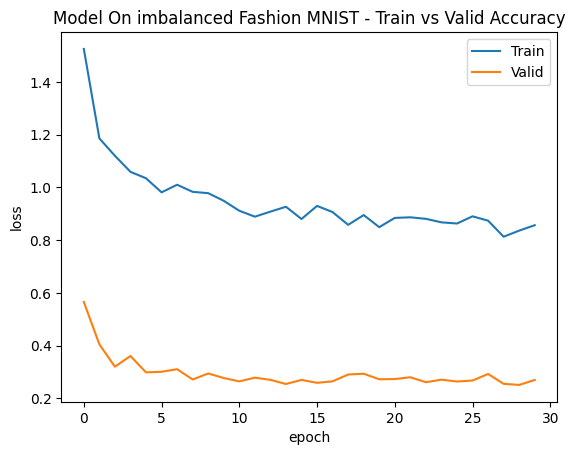

In [18]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Model On imbalanced Fashion MNIST - Train vs Valid Accuracy')

plt.show()

In [19]:
print("On Imbalanced Fashion MNIST dataset")
test_acc2, class_percentages2 = test(imbalanced_model_cutmix, "imbalanced_model_cutmix.pth")
print("test accuracy : ", str(test_acc2))

On Imbalanced Fashion MNIST dataset

Test dataset: Overall Loss: 0.0009, Overall Accuracy: 8511/10000 (85%)

test accuracy :  85.11


## MixUp


In [20]:
def mixup(data, targets, alpha):
    """

        :param data: torch.Size. Shape:(batch_size, channel, image_size, image_size)
        :param targets: torch.Tensor. multitask, multi-classification, target1. shape(batch_size, 1)
        :param alpha: float, positive
        :return: resulting image, multi-target
        """
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets, shuffled_targets, lam]

    return data, targets

In [21]:
def train_mixup(train_dataloader, valid_dataloader, PATH, model = None, criterion= F.cross_entropy, epochs=1):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    model.train()
    best_acc = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        losses = 0.0
        for b_i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            X, ys = mixup(X, y, alpha=0.5)
            pred_prob = model(X)
            targets1, targets2, lam = ys[0], ys[1], ys[2]
            loss = lam * criterion(pred_prob, targets1) + (1 - lam) * criterion(pred_prob, targets2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += loss.item()
            if b_i % 10 == 0:
                print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                    epoch, b_i, len(train_dataloader),
                    100. * b_i / len(train_dataloader), loss.item()))

        train_losses.append(losses/len(train_dataloader))

        print("\n")
        print("Validation...")
        model.eval()
        loss = 0
        success = 0
        with torch.no_grad():
            for X, y in valid_dataloader:
                X, y = X.to(device), y.to(device)
                pred_prob = model(X)
                loss += criterion(pred_prob, y, reduction='sum').item()  # loss summed across the batch
                pred = pred_prob.argmax(dim=1, keepdim=True)  # use argmax to get the most likely prediction
                success += pred.eq(y.view_as(pred)).sum().item()

        loss /= len(valid_dataloader.dataset)

        val_losses.append(loss)

        accuracy = 100. * success / len(valid_dataloader.dataset)

        if (accuracy > best_acc):
          torch.save(model.state_dict(), PATH)
          best_acc = accuracy

        print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
            loss, success, len(valid_dataloader.dataset), accuracy))
    return model, train_losses, val_losses

In [22]:
imbalanced_model_mixup, train_losses, val_losses = train_mixup(imbalanced_train_loader, imbalanced_valid_loader, "imbalanced_model_mixup.pth", ConvNet().to(device), epochs=30)

epoch: 0 [0/115 (0%)]	 training loss: 2.294178
epoch: 0 [10/115 (9%)]	 training loss: 1.920022
epoch: 0 [20/115 (17%)]	 training loss: 1.745943
epoch: 0 [30/115 (26%)]	 training loss: 0.961535
epoch: 0 [40/115 (35%)]	 training loss: 0.857859
epoch: 0 [50/115 (43%)]	 training loss: 1.088710
epoch: 0 [60/115 (52%)]	 training loss: 1.435028
epoch: 0 [70/115 (61%)]	 training loss: 1.787086
epoch: 0 [80/115 (70%)]	 training loss: 0.839230
epoch: 0 [90/115 (78%)]	 training loss: 1.395820
epoch: 0 [100/115 (87%)]	 training loss: 0.714784
epoch: 0 [110/115 (96%)]	 training loss: 0.659399


Validation...

Test dataset: Overall Loss: 0.3921, Overall Accuracy: 24491/36570 (67%)

epoch: 1 [0/115 (0%)]	 training loss: 1.047242
epoch: 1 [10/115 (9%)]	 training loss: 0.810812
epoch: 1 [20/115 (17%)]	 training loss: 1.532399
epoch: 1 [30/115 (26%)]	 training loss: 0.906694
epoch: 1 [40/115 (35%)]	 training loss: 0.755777
epoch: 1 [50/115 (43%)]	 training loss: 0.751352
epoch: 1 [60/115 (52%)]	 trainin

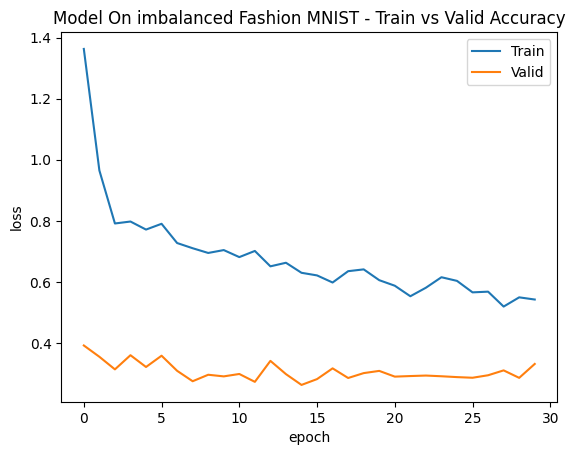

In [23]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Model On imbalanced Fashion MNIST - Train vs Valid Accuracy')

plt.show()

In [24]:
print("On Imbalanced Fashion MNIST dataset")
test_acc3, class_percentages3 = test(imbalanced_model_mixup, "imbalanced_model_mixup.pth")
print("test accuracy : ", str(test_acc3))

On Imbalanced Fashion MNIST dataset

Test dataset: Overall Loss: 0.0010, Overall Accuracy: 8484/10000 (85%)

test accuracy :  84.84


In [25]:
def train_cutmix_mixup(train_dataloader, valid_dataloader, PATH, model = None, criterion= F.cross_entropy, epochs=1):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    model.train()
    best_acc = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        losses = 0.0
        for b_i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            mix_decision = np.random.rand()
            if mix_decision < 0.5:
               X, ys = mixup(X, y, alpha=0.5)
            if mix_decision >= 0.5:
               X, ys = cutmix(X, y, alpha=0.5)
            pred_prob = model(X)
            targets1, targets2, lam = ys[0], ys[1], ys[2]
            loss = lam * criterion(pred_prob, targets1) + (1 - lam) * criterion(pred_prob, targets2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += loss.item()
            if b_i % 10 == 0:
                print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                    epoch, b_i, len(train_dataloader),
                    100. * b_i / len(train_dataloader), loss.item()))

        train_losses.append(losses/len(train_dataloader))

        print("\n")
        print("Validation...")
        model.eval()
        loss = 0
        success = 0
        with torch.no_grad():
            for X, y in valid_dataloader:
                X, y = X.to(device), y.to(device)
                pred_prob = model(X)
                loss += criterion(pred_prob, y, reduction='sum').item()  # loss summed across the batch
                pred = pred_prob.argmax(dim=1, keepdim=True)  # use argmax to get the most likely prediction
                success += pred.eq(y.view_as(pred)).sum().item()

        loss /= len(valid_dataloader.dataset)

        val_losses.append(loss)

        accuracy = 100. * success / len(valid_dataloader.dataset)

        if (accuracy > best_acc):
          torch.save(model.state_dict(), PATH)
          best_acc = accuracy

        print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
            loss, success, len(valid_dataloader.dataset), accuracy))
    return model, train_losses, val_losses

In [26]:
imbalanced_model_cutmix_mixup, train_losses, val_losses = train_mixup(imbalanced_train_loader, imbalanced_valid_loader, "imbalanced_model_cutmix_mixup.pth", ConvNet().to(device), epochs=30)

epoch: 0 [0/115 (0%)]	 training loss: 2.307527
epoch: 0 [10/115 (9%)]	 training loss: 1.425300
epoch: 0 [20/115 (17%)]	 training loss: 1.952045
epoch: 0 [30/115 (26%)]	 training loss: 0.925945
epoch: 0 [40/115 (35%)]	 training loss: 0.835586
epoch: 0 [50/115 (43%)]	 training loss: 1.073733
epoch: 0 [60/115 (52%)]	 training loss: 0.794178
epoch: 0 [70/115 (61%)]	 training loss: 1.265290
epoch: 0 [80/115 (70%)]	 training loss: 0.546634
epoch: 0 [90/115 (78%)]	 training loss: 0.529446
epoch: 0 [100/115 (87%)]	 training loss: 1.876281
epoch: 0 [110/115 (96%)]	 training loss: 0.610584


Validation...

Test dataset: Overall Loss: 0.4157, Overall Accuracy: 24662/36570 (67%)

epoch: 1 [0/115 (0%)]	 training loss: 1.451730
epoch: 1 [10/115 (9%)]	 training loss: 1.059271
epoch: 1 [20/115 (17%)]	 training loss: 0.463286
epoch: 1 [30/115 (26%)]	 training loss: 1.240414
epoch: 1 [40/115 (35%)]	 training loss: 0.786481
epoch: 1 [50/115 (43%)]	 training loss: 1.065792
epoch: 1 [60/115 (52%)]	 trainin

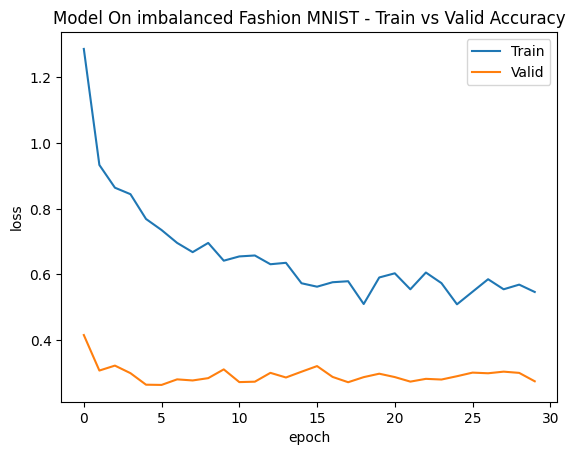

In [27]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Model On imbalanced Fashion MNIST - Train vs Valid Accuracy')

plt.show()

In [28]:
print("On Imbalanced Fashion MNIST dataset")
test_acc4, class_percentages4 = test(imbalanced_model_cutmix_mixup, "imbalanced_model_cutmix_mixup.pth")
print("test accuracy : ", str(test_acc4))

On Imbalanced Fashion MNIST dataset

Test dataset: Overall Loss: 0.0011, Overall Accuracy: 8485/10000 (85%)

test accuracy :  84.85


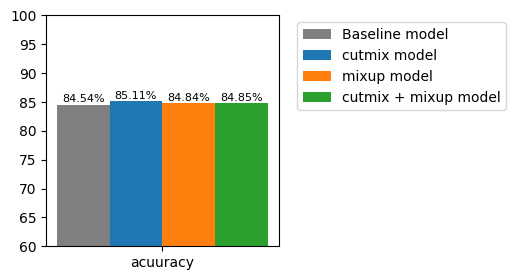

In [34]:
fig= plt.subplots(figsize=(3, 3))

br1 = np.arange(1)
br2 = [x + 0.1 for x in br1]
br3 = [x + 0.1 for x in br2]
br4 = [x + 0.1 for x in br3]

p1 = plt.bar(br1, np.array(test_acc1).astype(float), width = 0.1, label ='Baseline model', color='gray')
p2 = plt.bar(br2, np.array(test_acc2).astype(float), width = 0.1, label ='cutmix model')
p3 = plt.bar(br3, np.array(test_acc3).astype(float), width = 0.1, label ='mixup model')
p4 = plt.bar(br4, np.array(test_acc4).astype(float), width = 0.1, label ='cutmix + mixup model')

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=8)
for rect1 in p2:
    height = rect1.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=8)
for rect1 in p3:
    height = rect1.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=8)
for rect1 in p4:
    height = rect1.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=8)

plt.xticks([r + 0.15 for r in range(1)],
        ['acuuracy'])
plt.ylim(60, 100)
# plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

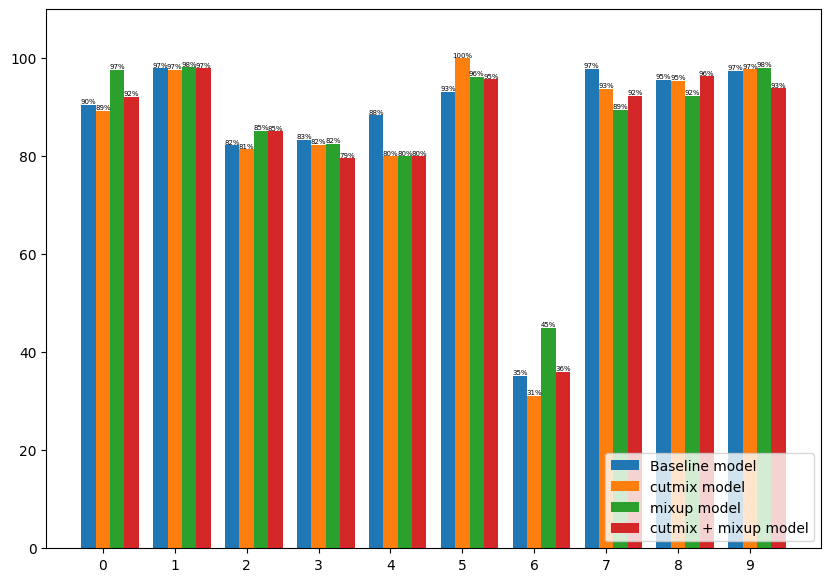

In [30]:
fig= plt.subplots(figsize=(10, 7))

br1 = np.arange(10)
br2 = [x + 0.2 for x in br1]
br3 = [x + 0.2 for x in br2]
br4 = [x + 0.2 for x in br3]

p1 = plt.bar(br1, np.array(class_percentages1).astype(float)*100.0, width = 0.2, label ='Baseline model')
p2 = plt.bar(br2, np.array(class_percentages2).astype(float)*100.0, width = 0.2, label ='cutmix model')
p3 = plt.bar(br3, np.array(class_percentages3).astype(float)*100.0, width = 0.2, label ='mixup model')
p4 = plt.bar(br4, np.array(class_percentages4).astype(float)*100.0, width = 0.2, label ='cutmix + mixup model')

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate( "{:.0f}%".format(int(height)),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=5)
for rect1 in p2:
    height = rect1.get_height()
    plt.annotate( "{:.0f}%".format(int(height)),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=5)
for rect1 in p3:
    height = rect1.get_height()
    plt.annotate( "{:.0f}%".format(int(height)),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=5)
for rect1 in p4:
    height = rect1.get_height()
    plt.annotate( "{:.0f}%".format(int(height)),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=5)

plt.xticks([r + 0.2 for r in range(10)],
        ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.ylim(0, 110)
plt.legend(loc='lower right')
plt.show()